In [32]:
import os
import duckdb
import time

In [ ]:
# Generate dummy data using DuckDB SQL
def gen_dataset(rows):

    lower_bound = "2020-01-01"
    upper_bound = "2025-01-01"  

    duckdb.execute(f"""
        COPY (
        select  
              t.row_id
            , cast(uuid() as varchar(30)) as txn_key
            , date '{lower_bound}' 
            + (random() * (date_diff('day', date '{lower_bound}', date '{upper_bound}')))::int as rand_dt
            , round(random() * 100, 2) as rand_val
            , substr(
                  'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789', 
                  1, 
                  1 + (random() * 25)::int
              ) as rand_str
        from generate_series(1,{rows}) t(row_id)
        ) TO '~/dummy_data/duckb_dataset_{rows}.parquet' (FORMAT 'parquet')
    """)


In [23]:
gen_dataset(500)
gen_dataset(5_000)
gen_dataset(50_000)
gen_dataset(500_000)
gen_dataset(5_000_000)
gen_dataset(50_000_000)
gen_dataset(500_000_000)


In [29]:
f_path = os.path.expanduser("~/dummy_data/duckb_dataset_*.parquet")

duckdb.sql(f"from read_parquet('{f_path}') limit 5").show()

┌────────┬──────────────────────────────────────┬────────────┬──────────┬───────────────────────────┐
│ row_id │               txn_key                │  rand_dt   │ rand_val │         rand_str          │
│ int64  │               varchar                │    date    │  double  │          varchar          │
├────────┼──────────────────────────────────────┼────────────┼──────────┼───────────────────────────┤
│      1 │ 6e7dae11-f7a0-45fc-99e4-b1835d580061 │ 2022-10-04 │    88.15 │ abcdefghijklmnopqrstuvwxy │
│      2 │ 358a0dd5-548a-4177-8d0c-d1166591738f │ 2021-10-12 │    53.25 │ abcdefghijklm             │
│      3 │ 819dcc8e-23cc-4a6e-92b6-a03bfc3adbac │ 2024-04-11 │     43.2 │ abcdefghijklmnop          │
│      4 │ 14d193b8-8de1-417c-a8b5-f06b8cba57bb │ 2021-07-09 │     0.89 │ abcdefghijklmnop          │
│      5 │ de3bc394-edc5-4494-91a7-196f5500b82b │ 2023-11-26 │    22.45 │ abcdefghijkl              │
└────────┴──────────────────────────────────────┴────────────┴──────────┴─────────

In [51]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = (SparkSession.builder 
        .appName("Sledgehammer") 
        .getOrCreate()  
)

In [ ]:
import glob
import os
import time
import duckdb

def duckdb_benchmark(parquet_files):
    cn = duckdb.connect()
    results = []
    for f_path in parquet_files:
        start = time.time()
        cn.sql(f"select rand_dt, count(distinct rand_str) from read_parquet('{f_path}') group by all order by 2 desc").fetchall()
        end = time.time()
        elapsed_ms = (end - start) * 1000
        row_count = cn.sql(f"select count(*) from read_parquet('{f_path}')").fetchone()[0]
        results.append((row_count, elapsed_ms))
        print(f"DuckDB | {os.path.basename(f_path)} | {row_count:,} rows | {elapsed_ms:.2f} ms")
    return results

def spark_benchmark(parquet_files, spark):
    results = []
    for f_path in parquet_files:
        start = time.time()
        df = spark.read.parquet(f_path)
        grouped = df.groupBy("rand_dt").agg(F.count_distinct("rand_str").alias("distinct_rand_str_count")).orderBy("distinct_rand_str_count", ascending=False)
        grouped.collect()
        end = time.time()
        elapsed_ms = (end - start) * 1000
        row_count = df.count()
        results.append((row_count, elapsed_ms))
        print(f"Spark  | {os.path.basename(f_path)} | {row_count:,} rows | {elapsed_ms:.2f} ms")
    return results

data_dir = os.path.expanduser("~/dummy_data/")
parquet_files = sorted(glob.glob(os.path.join(data_dir, "duckb_dataset_*.parquet")))

duckdb_results = duckdb_benchmark(parquet_files)
spark_results = spark_benchmark(parquet_files, spark)



DuckDB | duckb_dataset_500.parquet | 500 rows | 7.28 ms
DuckDB | duckb_dataset_5000.parquet | 5,000 rows | 5.02 ms
DuckDB | duckb_dataset_50000.parquet | 50,000 rows | 7.07 ms
DuckDB | duckb_dataset_500000.parquet | 500,000 rows | 12.71 ms
DuckDB | duckb_dataset_5000000.parquet | 5,000,000 rows | 79.35 ms
DuckDB | duckb_dataset_50000000.parquet | 50,000,000 rows | 341.16 ms
DuckDB | duckb_dataset_500000000.parquet | 500,000,000 rows | 2648.06 ms
Spark  | duckb_dataset_500.parquet | 500 rows | 210.74 ms
Spark  | duckb_dataset_5000.parquet | 5,000 rows | 184.39 ms
Spark  | duckb_dataset_50000.parquet | 50,000 rows | 202.29 ms
Spark  | duckb_dataset_500000.parquet | 500,000 rows | 257.04 ms
Spark  | duckb_dataset_5000000.parquet | 5,000,000 rows | 561.60 ms


Spark  | duckb_dataset_50000000.parquet | 50,000,000 rows | 1341.11 ms


Spark  | duckb_dataset_500000000.parquet | 500,000,000 rows | 10150.79 ms


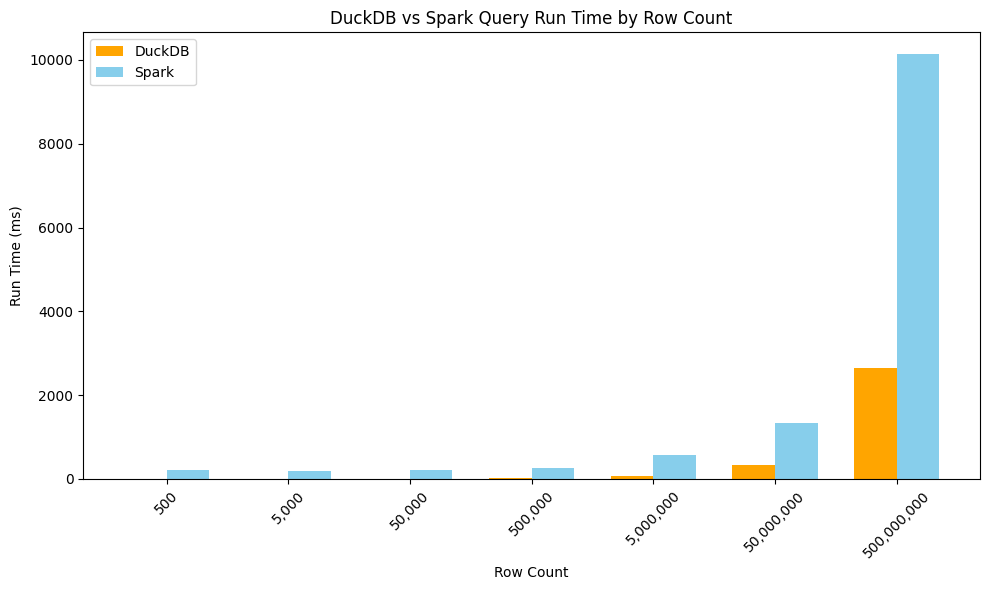

In [56]:
import matplotlib.pyplot as plt

row_counts = [r[0] for r in duckdb_results]
duckdb_times = [r[1] for r in duckdb_results]
spark_times = [r[1] for r in spark_results]

plt.figure(figsize=(10, 6))
bar_width = 0.35
x = range(len(row_counts))

plt.bar(x, duckdb_times, width=bar_width, label='DuckDB', color='orange')
plt.bar([i + bar_width for i in x], spark_times, width=bar_width, label='Spark', color='skyblue')

plt.xlabel('Row Count')
plt.ylabel('Run Time (ms)')
plt.title('DuckDB vs Spark Query Run Time by Row Count')
plt.xticks([i + bar_width / 2 for i in x], [f"{rc:,}" for rc in row_counts], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()